In [21]:
import pandas as pd
import json
import os
import ast 
import re
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn import preprocessing


import numpy as np
from tqdm import tqdm
import chardet
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px

from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import textblob
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import math
from nltk import bigrams,trigrams,ngrams
from collections import Counter
from sklearn.metrics import confusion_matrix
from nltk import everygrams, word_tokenize
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_confusion_matrix

# Deal with business data

In [2]:
business = pd.read_json('./business.json',lines = True)
CA_business = business[business['state'] == 'CA']
CA_business = CA_business.reset_index()

In [3]:
for i in range(len(CA_business)):
    cur_attr = CA_business['attributes'][i]
    if bool(cur_attr) == False:
        continue
    for key in cur_attr.keys():
        CA_business.loc[i,key] = cur_attr[key]


def extract_info (df, feature):
    for i in range(len(df)):
        try:
            cur_attr = df[feature][i]
            cur_attr = ast.literal_eval(cur_attr)
            for key in cur_attr.keys():
                df.loc[i,key] = cur_attr[key]
        except: 
            continue

            
def extract_info_hours (df, feature):
    for i in range(len(df)):
        try:
            cur_attr = df[feature][i]
            #cur_attr = ast.literal_eval(cur_attr)
            for key in cur_attr.keys():
                df.loc[i,key] = cur_attr[key]
        except: 
            continue
            
extract_info(CA_business,'BusinessParking')    
extract_info(CA_business,'GoodForMeal')     
extract_info(CA_business,'Ambience')     
extract_info_hours(CA_business,'hours')     
     
        
CA_business = CA_business.drop(columns=['attributes','BusinessParking','GoodForMeal','Ambience'])
CA_business = CA_business.rename({'stars':'average_stars'},axis = 1)

In [4]:
#Leave non-NA categories and clean it up, then find those contain certain words
temp_business = CA_business[CA_business['categories'].notna()].reset_index(drop = True)
temp_business['category_cleaned'] = temp_business['categories'].str.split()
temp_business['category_cleaned'] = temp_business['category_cleaned'].apply(lambda x : [re.sub(r'[.,"\'-?:!;]', '', i) for i in x])
temp_business['category_cleaned'] = temp_business['category_cleaned'].apply(lambda x : [re.sub(r'\<a href', ' ', i) for i in x])
temp_business['category_cleaned'] = temp_business['category_cleaned'].apply(lambda x : [re.sub(r'&amp;', '', i) for i in x])
temp_business['category_cleaned'] = temp_business['category_cleaned'].apply(lambda x : [re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', i) for i in x])
temp_business['category_cleaned'] = temp_business['category_cleaned'].apply(lambda x : [re.sub(r'<br />', ' ', i) for i in x])
temp_business['category_cleaned'] = temp_business['category_cleaned'].apply(lambda x : [re.sub(r'\'', ' ', i) for i in x])
temp_business['category_cleaned'] = temp_business['category_cleaned'].apply(lambda x: [item.lower() for item in x])


Asian_keyword = ['Chinese','Korean','Japanese','Asian','Sushi','Taiwan','Taiwaness','Hongkong','noodles','dumplings']
Asian_keyword = [name.lower() for name in Asian_keyword]
Asian_business_id1 = []
for i in range(len(temp_business)):
    cur_cat = temp_business.loc[i,'category_cleaned']
    try: 
        if any(item in cur_cat for item in Asian_keyword):
            Asian_business_id1.append(temp_business.loc[i,'business_id'])
    except: continue

In [5]:
#Leave non-NA name and clean it up, then find those contain certain words
temp_business = CA_business[CA_business['name'].notna()].reset_index(drop = True)
temp_business['name_cleaned'] = temp_business['name'].str.split()
temp_business['name_cleaned'] = temp_business['name_cleaned'].apply(lambda x : [re.sub(r'[.,"\'-?:!;]', '', i) for i in x])
temp_business['name_cleaned'] = temp_business['name_cleaned'].apply(lambda x : [re.sub(r'\<a href', ' ', i) for i in x])
temp_business['name_cleaned'] = temp_business['name_cleaned'].apply(lambda x : [re.sub(r'&amp;', '', i) for i in x])
temp_business['name_cleaned'] = temp_business['name_cleaned'].apply(lambda x : [re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', i) for i in x])
temp_business['name_cleaned'] = temp_business['name_cleaned'].apply(lambda x : [re.sub(r'<br />', ' ', i) for i in x])
temp_business['name_cleaned'] = temp_business['name_cleaned'].apply(lambda x : [re.sub(r'\'', ' ', i) for i in x])
temp_business['name_cleaned'] = temp_business['name_cleaned'].apply(lambda x: [item.lower() for item in x])


Asian_keyword = ['Chinese','Korean','Japanese','Asian','Sushi','Taiwan','Taiwaness','Hongkong','noodles','dumplings']
Asian_keyword = [name.lower() for name in Asian_keyword]
Asian_business_id2 = []
for i in range(len(temp_business)):
    cur_cat = temp_business.loc[i,'name_cleaned']
    try: 
        if any(item in cur_cat for item in Asian_keyword):
            Asian_business_id2.append(temp_business.loc[i,'business_id'])
    except: continue

In [6]:
Asian_business_id = set(Asian_business_id1+Asian_business_id2)
CA_Asian_food = CA_business[CA_business['business_id'].isin(Asian_business_id)].reset_index(drop = True)
#CA_Asian_food = CA_business[CA_business.name.str.contains('|'.join(Asian_list))]

In [7]:
# Remove records that has certain keywords that is related to other categories
non_restaurant_list = ['Medicine', 'Health','Meical','Acupuncture','Massage']
non_restuarant_id = []
for i in range(len(CA_Asian_food)):
    cur_cat = CA_Asian_food.loc[i,'categories']
    try: 
        if any(item in cur_cat for item in non_restaurant_list):
            non_restuarant_id.append(CA_Asian_food.loc[i,'business_id'])
    except: continue
        
CA_Asian_food = CA_Asian_food[~CA_Asian_food['business_id'].isin(non_restuarant_id)].reset_index(drop = True)

In [16]:
boba_tea_list = ['Bubble Tea','Boba tea']
boba_tea_business_id = []
for i in range(len(CA_Asian_food)):
    cur_cat = CA_Asian_food.loc[i,'categories']
    try: 
        if any(item in cur_cat for item in boba_tea_list):
            boba_tea_business_id.append(CA_Asian_food.loc[i,'business_id'])
    except: continue

len(boba_tea_list)

2

# Visualize heatmap of business data

In [25]:
def encoder(df, feature):
    le = preprocessing.LabelEncoder()
    df[feature] = le.fit_transform(df[feature])

encode_list = [ 'city', 'state',
       'postal_code', 
    'is_open', 'ByAppointmentOnly',
       'BusinessAcceptsCreditCards', 'BikeParking', 'RestaurantsPriceRange2',
       'RestaurantsTakeOut', 'NoiseLevel', 'Caters', 'RestaurantsReservations',
       'RestaurantsTableService', 'GoodForKids', 'WheelchairAccessible',
       'OutdoorSeating', 'RestaurantsDelivery', 'HasTV', 'RestaurantsAttire',
       'Alcohol', 'DogsAllowed', 'RestaurantsGoodForGroups', 'HappyHour',
       'WiFi', 'BusinessAcceptsBitcoin', 'CoatCheck',
       'Smoking', 'BYOB', 'DriveThru', 'Corkage', 'BYOBCorkage',
       'GoodForDancing', 'AcceptsInsurance', 'HairSpecializesIn',
       'AgesAllowed', 'RestaurantsCounterService', 'Open24Hours',
       'DietaryRestrictions', 'garage', 'street', 'validated', 'lot', 'valet',
       'dessert', 'latenight', 'lunch', 'dinner', 'brunch', 'breakfast',
       'touristy', 'hipster', 'romantic', 'divey', 'intimate', 'trendy',
       'upscale', 'classy', 'casual'
]

temp_CA_Asian_food = CA_Asian_food.copy()
for i in encode_list:
    encoder(temp_CA_Asian_food, i)



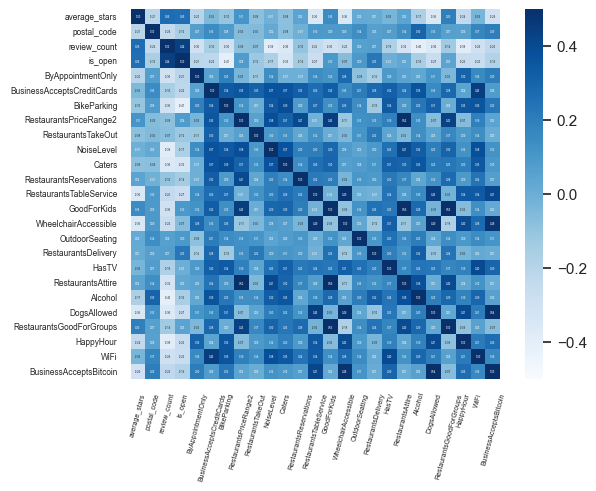

In [75]:
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
sns.set(font_scale=1)
hm = sns.heatmap(temp_CA_Asian_food[[
       'average_stars', 'postal_code',  'review_count',
       'is_open', 'ByAppointmentOnly',
       'BusinessAcceptsCreditCards', 'BikeParking', 'RestaurantsPriceRange2',
       'RestaurantsTakeOut', 'NoiseLevel', 'Caters', 'RestaurantsReservations',
       'RestaurantsTableService', 'GoodForKids', 'WheelchairAccessible',
       'OutdoorSeating', 'RestaurantsDelivery', 'HasTV', 'RestaurantsAttire',
       'Alcohol', 'DogsAllowed', 'RestaurantsGoodForGroups', 'HappyHour',
       'WiFi', 'BusinessAcceptsBitcoin'
]].corr(), cbar=True, vmin=-0.5, vmax=0.5,
                 fmt='.2f', annot_kws={'fontsize': 2}, annot=True, 
                 square=True, cmap=plt.cm.Blues)

# ax.set_xticks(temp_CA_Asian_food.columns)
# ax.set_xticklabels(temp_CA_Asian_food.columns, rotation=90, fontsize=8)
# ax.set_yticks(temp_CA_Asian_food.columns)
# ax.set_yticklabels(temp_CA_Asian_food.index, rotation=360, fontsize=8)

hm.set_yticklabels(hm.get_yticklabels(), fontsize = 6)
hm.set_xticklabels(hm.get_xticklabels(), fontsize = 5, rotation = 75)
plt.savefig('hm1.png',dpi = 600)

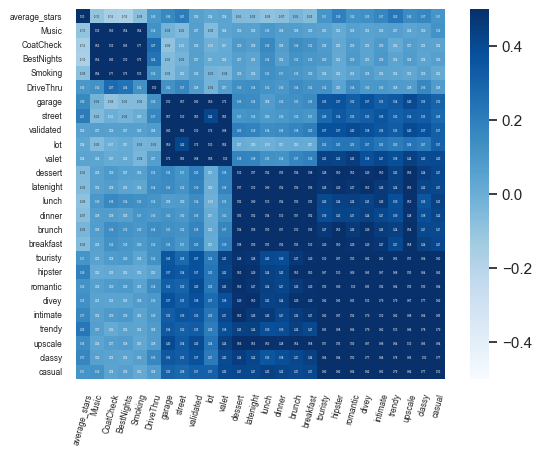

In [71]:
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
sns.set(font_scale=1)
hm = sns.heatmap(temp_CA_Asian_food[[
       'average_stars', 'Music', 'CoatCheck', 'BestNights',
       'Smoking', 'DriveThru',
        'garage', 'street', 'validated', 'lot', 'valet',
       'dessert', 'latenight', 'lunch', 'dinner', 'brunch', 'breakfast',
       'touristy', 'hipster', 'romantic', 'divey', 'intimate', 'trendy',
       'upscale', 'classy', 'casual'
]].corr(), cbar=True, vmin=-0.5, vmax=0.5,
                 fmt='.2f', annot_kws={'fontsize': 2}, annot=True, 
                 square=True, cmap=plt.cm.Blues,xticklabels=True, yticklabels=True)

# ax.set_xticks(temp_CA_Asian_food.columns)
# ax.set_xticklabels(temp_CA_Asian_food.columns, rotation=90, fontsize=8)
# ax.set_yticks(temp_CA_Asian_food.columns)
# ax.set_yticklabels(temp_CA_Asian_food.index, rotation=360, fontsize=8)

hm.set_yticklabels(hm.get_yticklabels(), fontsize = 6)
hm.set_xticklabels(hm.get_xticklabels(), fontsize = 6, rotation = 75)

plt.savefig('hm2.png',dpi = 300)

# Turn Monday-Sunday working hour to length

In [9]:
def convert_hour(time):
    result = 0
    if len(time) == 5:
        if time[-2] == '00':
            result = int(time[:-3])
        elif int(time[-2]) > 15:
            result = int(time[:-3])+1
        else:
            result = int(time[:-3])
    elif len(time) == 4:
        if time[-1] == '0':
            result = int(time[:-2])
        elif int(time[-1]) > 15:
            result = int(time[:-2])+1
        else:
            result = int(time[:-2])
    else:
        if time[-1] == '0':
            result = int(time[:-2])
        elif int(time[-1]) > 15:
            result = int(time[:-2])+1
        else:
            result = int(time[:-2])
    return result

def calculate_total_hour(feature, new_feature):
    for i in range(len(CA_Asian_food)):
        try:
            cur_schedule =  CA_Asian_food.loc[i,feature]
            ls = cur_schedule.split('-')
            if ls[0] == ls[1]:
                CA_Asian_food.loc[i,new_feature] = 24
            else:
                if(ls[1] == '0:0'):
                    CA_Asian_food.loc[i,new_feature] = 24 - convert_hour(ls[0])
                elif(convert_hour(ls[1]) < convert_hour(ls[0])):
                    CA_Asian_food.loc[i,new_feature] = 24 + convert_hour(ls[1]) - convert_hour(ls[0])
                else:
                    work_hour = convert_hour(ls[1])-convert_hour(ls[0])
                    CA_Asian_food.loc[i,new_feature] = work_hour
        except: 
            continue
        

calculate_total_hour('Monday','Monday_working_length')
calculate_total_hour('Tuesday','Tuesday_working_length')
calculate_total_hour('Wednesday','Wednesday_working_length')
calculate_total_hour('Thursday','Thursday_working_length')
calculate_total_hour('Friday','Friday_working_length')
calculate_total_hour('Saturday','Saturday_working_length')
calculate_total_hour('Sunday','Sunday_working_length')

#CA_Asian_food.columns
#CA_Asian_food = CA_Asian_food.drop(columns=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']).reset_index(drop = True)

# Read and combine reivew with business

In [11]:
review = pd.read_csv('./review.csv')
review = review.rename({'stars':'comment_star'},axis = 1)
review.head()

,review_id,user_id,business_id,comment_star,date,text
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,2018-07-07 22:09:11,"If you decide to eat here, just be aware it is..."
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,2012-01-03 15:28:18,I've taken a lot of spin classes over the year...
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,2014-02-05 20:30:30,Family diner. Had the buffet. Eclectic assortm...
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,2015-01-04 00:01:03,"Wow! Yummy, different, delicious. Our favo..."
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,2017-01-14 20:54:15,Cute interior and owner (?) gave us tour of up...


In [12]:
frames = [CA_Asian_food, review]
CA_Asian_business_review = pd.merge(review, CA_Asian_food,left_on='business_id',right_on = 'business_id', how = 'right' ).reset_index(drop=True)
CA_Asian_business_review.to_csv('CA_Asian_business_review.csv',index = False)

In [13]:
CA_Asian_food[CA_Asian_food['business_id'] == 'wK2IixmZUOEFGz1QZqR99Q']

,index,business_id,name,address,city,state,postal_code,latitude,longitude,average_stars,...,Friday,Saturday,Sunday,Monday_working_length,Tuesday_working_length,Wednesday_working_length,Thursday_working_length,Friday_working_length,Saturday_working_length,Sunday_working_length
94,101154,wK2IixmZUOEFGz1QZqR99Q,Lovejoy's Pickle Room,126 E Canon Perdido,Santa Barbara,CA,93101,34.422161,-119.698619,4.0,...,16:30-1:0,16:30-1:0,NaN,8.0,8.0,9.0,9.0,9.0,9.0,NaN
